In [1]:
import time
import warnings
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from astropy import units as u
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier
from astroquery.ipac.ned import Ned
from astropy.io import fits
from scipy.optimize import curve_fit,  fsolve
from io import BytesIO
import sympy as smp
from astropy.table import Table
from scipy.interpolate import interp1d
from astropy.convolution import convolve_fft, Gaussian2DKernel

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
warnings.filterwarnings('ignore')
import ztfidr
import galaxy_phot as glp

sample = ztfidr.get_sample()
host_data = ztfidr.io.get_host_data()

conds1 = (sample.data['redshift'] > 0 ) & (sample.data['redshift'] < 0.2) 
conds2 = np.intersect1d(host_data.index, sample.data.index)
data = host_data[['host_ra', 'host_dec']].loc[conds2].dropna()[conds1]
targets = data.index

# df10 = Table.read('fits_files/survey-bricks-dr10-south.fits.gz', format='fits')

In [2]:
importlib.reload(glp) # 'ZTF19acmvrsw', ZTF20aaummmc, ZTF20acwmpsj

<module 'galaxy_phot' from 'c:\\Users\\Robert\\PycharmProjects\\galaxies\\galaxy_phot.py'>

In [3]:
sn_name = targets[622] # 2321, 622, 2011, 2027, 2028, 2040, 600, 605, 606, 607, 608, 612, 624, 625, 627, 628, 629, 631, 632, 635, 641, 651
# sn_name = 'ZTF19acihlft' 
# sn_name = 'ZTF20acwmpsj'
gd = glp.galaxy_decomp(sn_name, verbose=True, mask=False, band='g', size=300, source='save', catalog='ztf')
gd.gobj.brick

ZTF18acatuts 336.49589303059406 3.4600505268453903 0.03683002 z_snid
dr10 300 300


{'brickname': '3365p035',
 'psfsize': 1.7104517,
 'psfdepth': 24.778942,
 'galdepth': 24.564114,
 'sky': -1.3217754e-05,
 'sky_mag': 63.114172814996316}

(<AxesSubplot:>, <AxesSubplot:>)

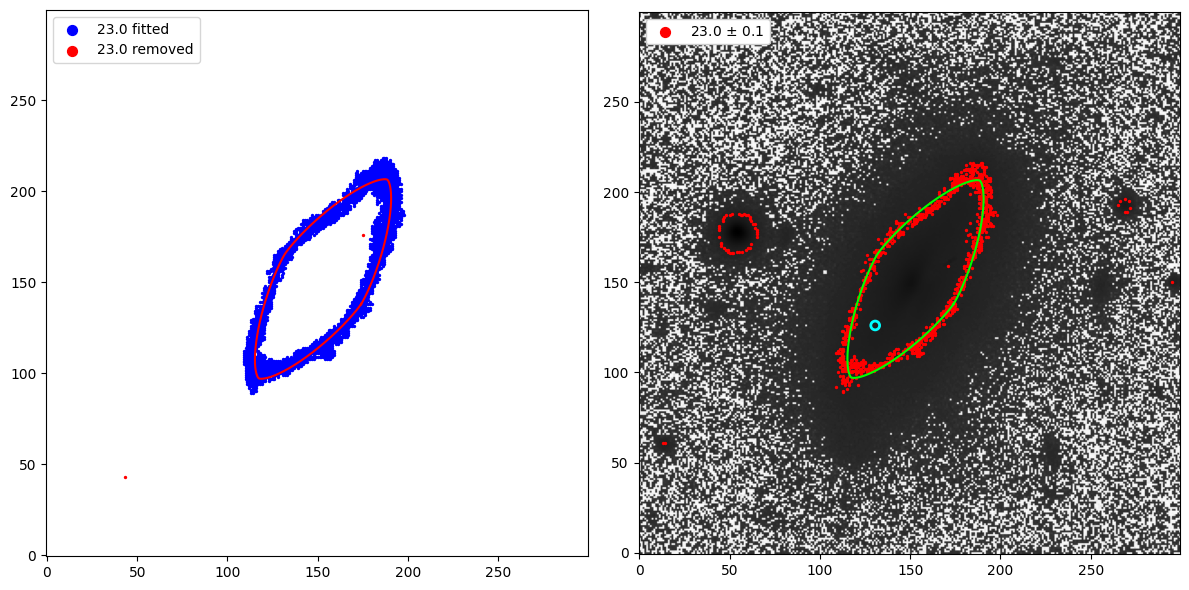

In [4]:
iso=23
gd.contour_fit(iso, mask=[])
gd.plot_fit([iso], width=0.1, zoom=False)

In [5]:
gd.main_run()

25.0
24.0
23.0
22.0
21.0
20.0


In [6]:
importlib.reload(glp)
bd = glp.BDdecomp(sn_name, gd)

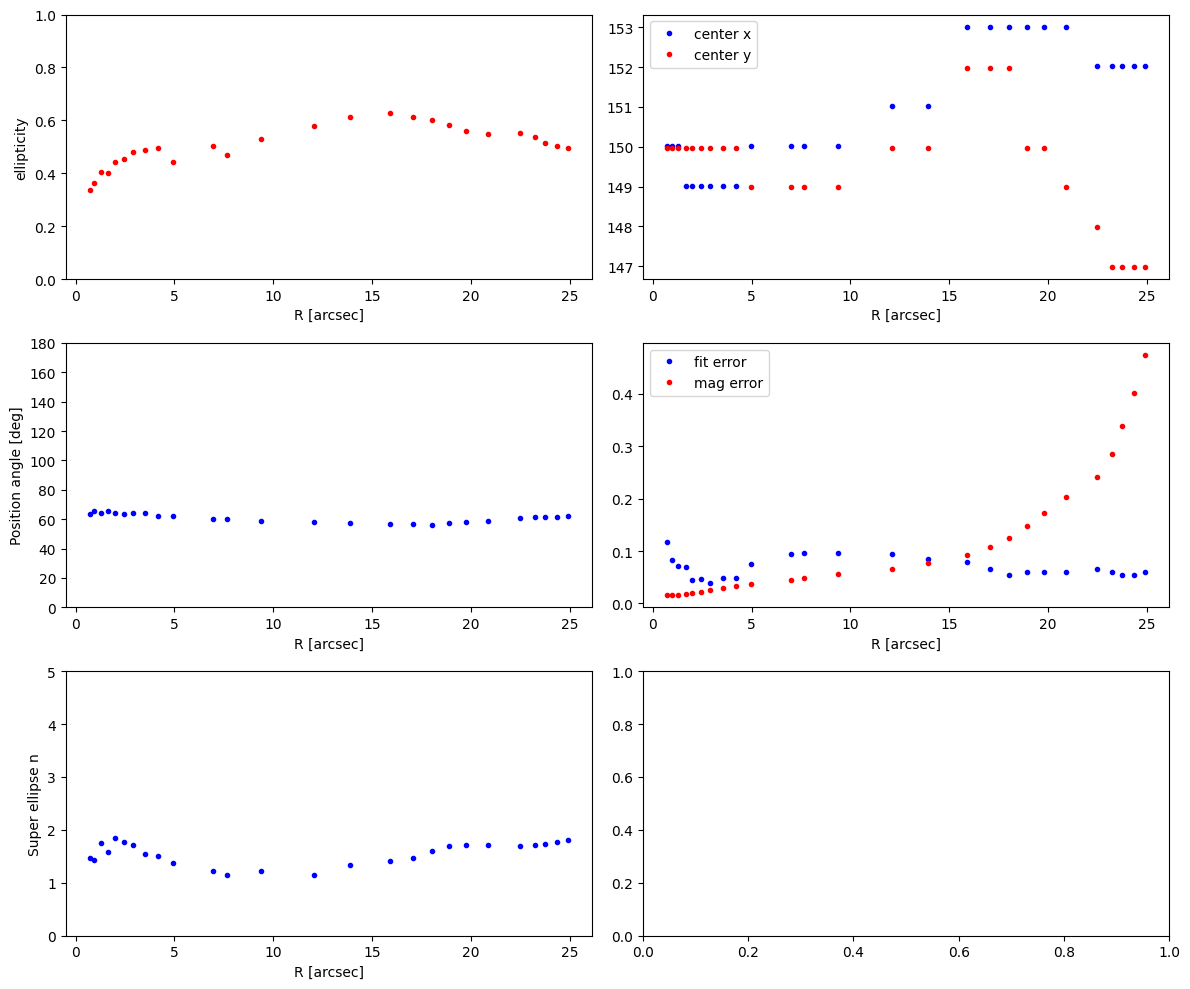

In [7]:
iso_out = bd.plot_iso()

In [8]:
bd.main_BD(spokes=12, mode=0)

One componenet, BIC: -1156.91, RSS: 6.85, fitted parameters: 6
Two componenet, BIC: -1363.81, RSS: 3.22, fitted parameters: 11


Bulge: $\mu(R) = \mu_e + \frac{2.5 b_n}{\ln 10} \left[(R/R_e)^{1/n} - 1\right]$, Free parameters: $\mu_e, R_e, n$

Disk: $\mu(R) = \mu_0 + \frac{2.5}{\ln 10} (R/h)$, Free parameters: $\mu_0, h$

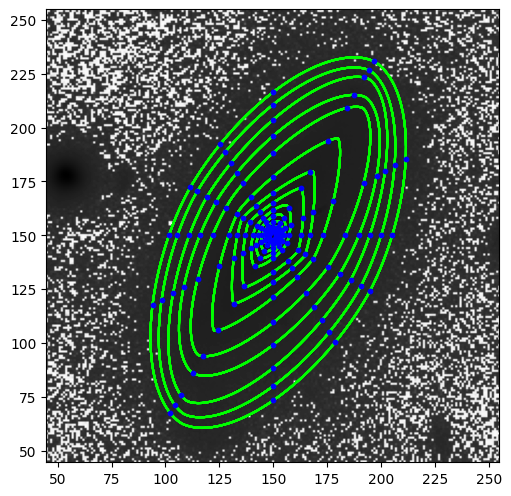

In [9]:
spokes=12
fig, ax = bd.plot_gal_iso(np.linspace(0, 360-360/spokes, spokes))

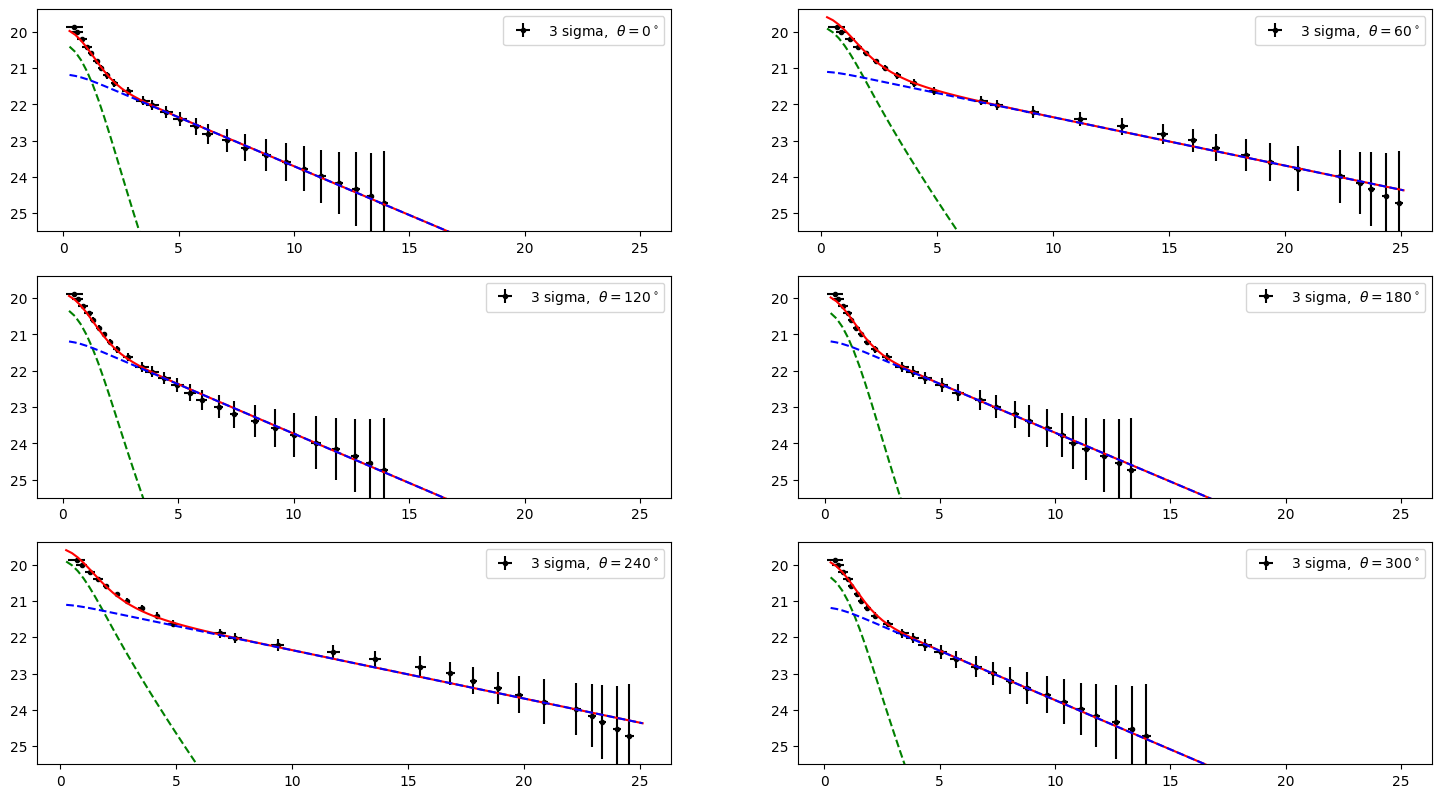

In [32]:
bd.plot_spokes(sigma=3, n_model=2)

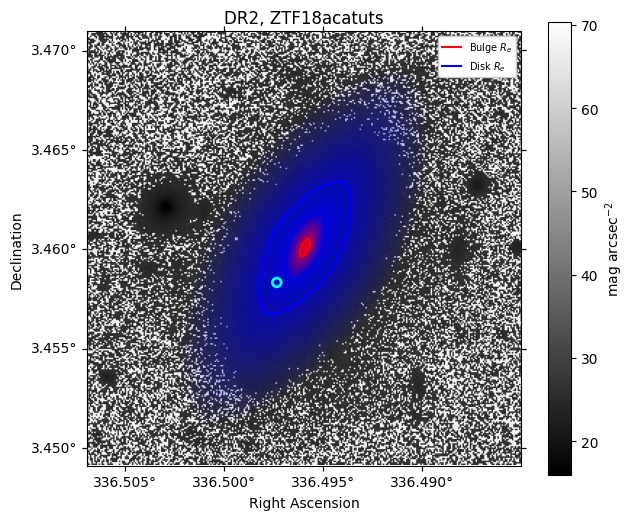

In [11]:
bd.plot_SB_profile(n_model=2)

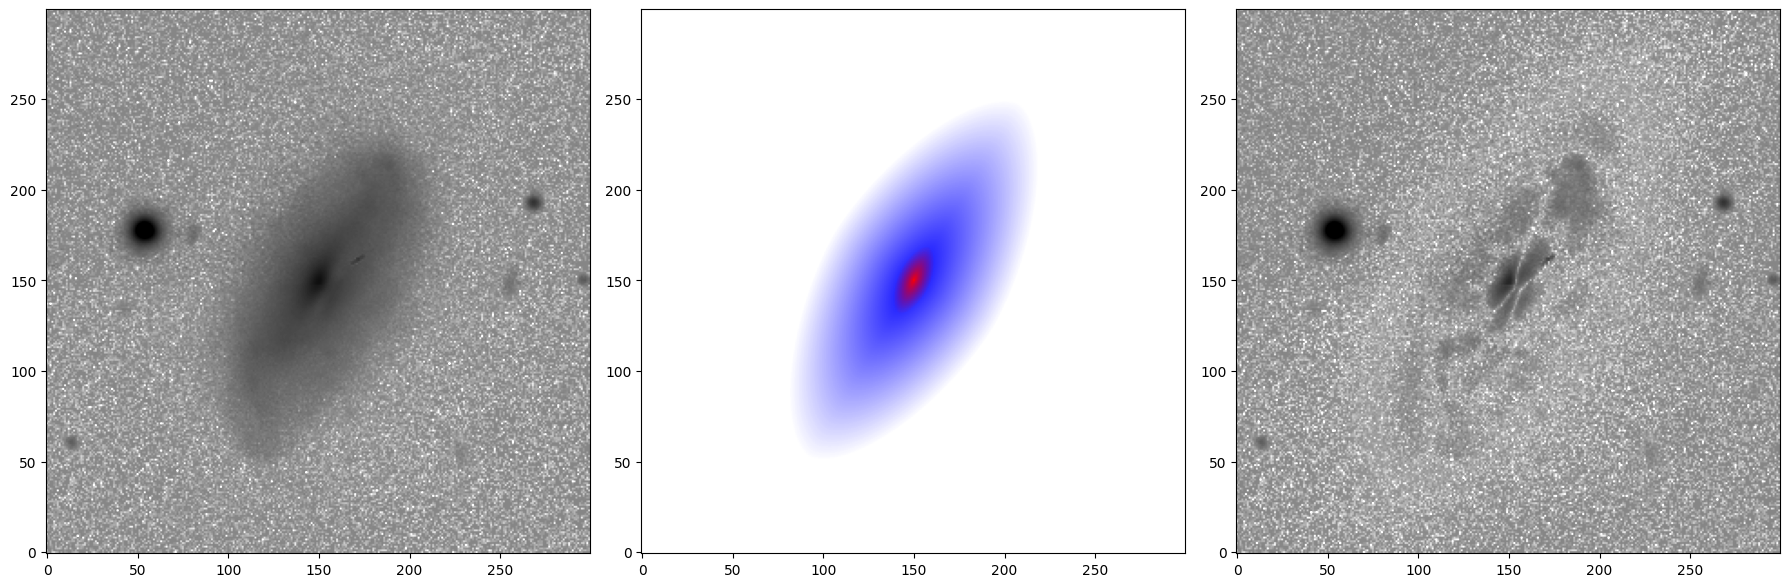

In [12]:
bd.plot_SB_profile(subtarct=True, n_model=2)

In [13]:
def psf_num(x, ue, re, n):
    r_r = np.linspace(-50, 50, 1000)
    psf_conv = -2.5*np.log10(10**(-0.4*ue)*convolve_fft(10**(-0.4*bd.bulge(r_r, 0, re, n)), bd.psf(r_r))) 
    return interp1d(r_r, psf_conv)(x)

In [18]:
r_r = np.linspace(-30, 30, 1000)
re = np.linspace(0, 30, 1000)

array([[10., 10., 10., ..., 10., 10., 10.],
       [10., 10., 10., ..., 10., 10., 10.],
       [10., 10., 10., ..., 10., 10., 10.],
       ...,
       [10., 10., 10., ..., 10., 10., 10.],
       [10., 10., 10., ..., 10., 10., 10.],
       [10., 10., 10., ..., 10., 10., 10.]])

In [31]:
r_r = np.linspace(1, 30, 300)
out = np.zeros(300**2)
for i, r in enumerate(r_r):
    out[i] = psf_num(r, 22, r, 1)

In [ ]:
# res_num = np.vectorize(psf_num)(np.ones((300, 300))*10, 22, np.ones((300, 300))*10, 2)

KeyboardInterrupt: 

In [ ]:
np.mean(np.abs(res_num-conv1))

0.010153792812746044

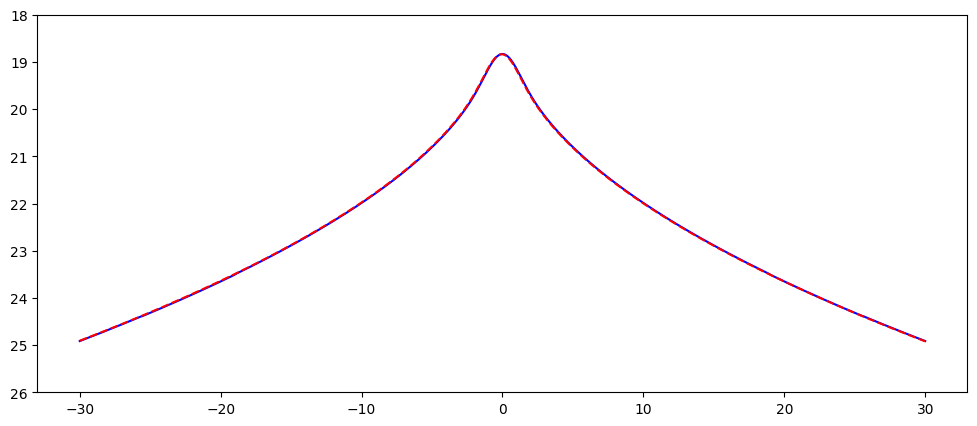

In [133]:
r_r = np.linspace(-30, 30, 1000)
# conv1 = bd.one_component(r_r, 22, 10, 2)
fig, ax = plt.subplots(figsize=(12,5), dpi=100)
# ax.plot(r_r, bd.bulge(r_r, 22, 10, 2), 'r-')
ax.plot(r_r, conv1, 'b-')
ax.plot(r_r, res_num, 'r--')
ax.set_ylim(18, 26)
ax.invert_yaxis()

In [ ]:
.

In [ ]:
def sub_mag(m1, m2):
    return -2.5*np.log10(10**(-0.4*m1) - 10**(-0.4*m2))

def sub_mag_a(m1, m2):
    return -2.5*np.log10(np.abs(10**(-0.4*m1) - 10**(-0.4*m2)))

std = gd.gobj.brick['psfsize']/(2*np.sqrt(2*np.log(2)))/0.262
kernal = Gaussian2DKernel(x_stddev=std, y_stddev=std)
both_airy = -2.5*np.log10(convolve_fft(10**(-0.4*both_arr_model), kernal))

both_arr_model.min(), both_airy.min(), gd.image[100:200, 100:200].min()

(18.98933822394114, 19.787713247637573, 19.322779028202586)

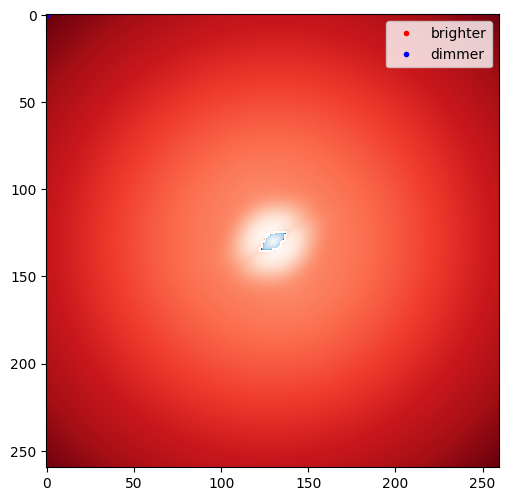

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.imshow(sub_mag(both_airy, both_arr_model)[20:-20, 20:-20], cmap='Reds')
ax.imshow(sub_mag(both_arr_model, both_airy)[20:-20, 20:-20], cmap='Blues')
ax.plot(0,0,'r.', label='brighter')
ax.plot(0,0,'b.', label='dimmer')
ax.legend()

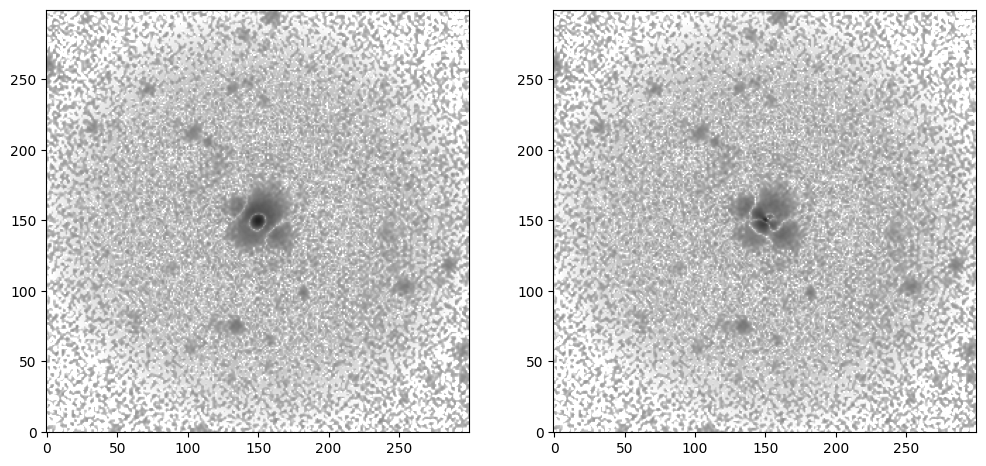

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), dpi=100, ncols=2)
ax1.imshow(sub_mag_a(gd.image, both_airy), cmap='gray', vmax=30, vmin=19, origin='lower')
ax2.imshow(sub_mag_a(gd.image, both_arr_model), cmap='gray', vmax=30, vmin=19, origin='lower')

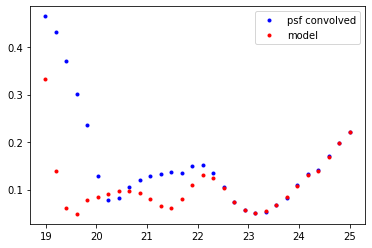

In [ ]:
targs = np.linspace(both_arr_model.min(), 25, 30)
accuracy = np.zeros((len(targs), 2))
for i, mag_i in enumerate(targs):
    c = (both_arr_model < mag_i+0.1) &  (both_arr_model > mag_i-0.1)
    accuracy[i] = np.mean(np.abs(gd.image[c] - both_airy[c])), np.mean(np.abs(gd.image[c] - both_arr_model[c]))

plt.plot(targs, accuracy.T[0], 'b.', label='psf convolved')
plt.plot(targs, accuracy.T[1], 'r.', label='model')
plt.legend()

In [ ]:
ai, bi, pai, ni, xci,yci, *erri = bd.iso_data.T[::-2][4]
ai1, bi1, pai1, ni1, xci1,yci1, *erri1 = bd.iso_data.T[::-2][0]

In [ ]:
def linear(x, a, b):
    return a*x+b

def stabilize(phi, theta, center0, center1, a, b, pa, n):
    vec = center1 - center0
    beta = np.arctan2(vec[1], vec[0])
    v_mag = np.sqrt(vec[0]**2 + vec[1]**2)
    r =  gd.super_ellipse(phi, a, b, pa, n)
    return v_mag * np.sin((theta - beta)) - r * np.sin((phi - theta))


a = [ai1, ai]
b = [bi1, bi]
pa = [pai1, pai]
n = [ni1, ni]

theta = np.deg2rad(30)
centers = np.array([[xci1,yci1], [xci+1.5, yci]])
phi = fsolve(stabilize, theta, args=(theta, centers[0], centers[1], a[1], b[1], pa[1], n[1]))
print(theta, phi)

0.5235987755982988 [0.61424498]


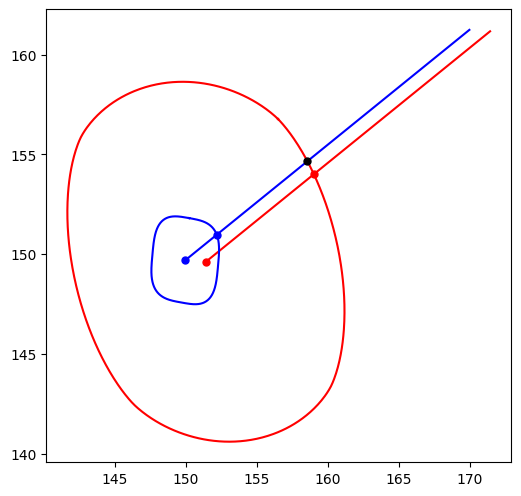

In [ ]:

colors = ['blue', 'red', 'lime', 'orange', 'purple', 'cyan']

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
for i in range(2):
    gd.patch_super_ellipse(pars=(a[i], b[i], pa[i], n[i]), center=centers[i], ax=ax, color=colors[i])
    ax.plot(centers[i][0], centers[i][1], 'k.', zorder=10, ms=10, c=colors[i])
    xi, yi = gd.super_ellipse(theta, a[i], b[i], pa[i], n[i], polar=False)
    ax.plot(xi+centers[i][0], yi+centers[i][1], 'k.', zorder=10, ms=10, color=colors[i])

    lx = np.linspace(centers[i][0], centers[i][0]+20)
    ax.plot(lx, linear(lx, yi/xi, -centers[i][0]*np.tan(theta) +centers[i][1]), 'k-', color=colors[i])


x_c, y_c = gd.super_ellipse(phi, a[1], b[1], pa[1], n[1], polar=False)
ax.plot(x_c+centers[i][0], y_c+centers[i][1], 'k.', zorder=10, ms=10)
# ax.set_ylim([-6, 8])
# ax.set_xlim([-12, 16])